<a href="https://colab.research.google.com/github/omeruncu1/Credit-Card-Approval-Prediction/blob/main/Credit_Card_Approval_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Approval Prediction

<a id="2"></a>
## Data Content
There're two tables could be merged by ID:


**application_record.csv**	:
- ID	Client: number
- CODE_GENDER:	Gender
- FLAG_OWN_CAR:	Is there a car
- FLAG_OWN_REALTY:	Is there a property
- CNT_CHILDREN:	Number of children
- AMT_INCOME_TOTAL:	Annual income
- NAME_INCOME_TYPE:	Income category
- NAME_EDUCATION_TYPE:	Education level
- NAME_FAMILY_STATUS:	Marital status
- NAME_HOUSING_TYPE:	Way of living
- DAYS_BIRTH:	Birthday	Count backwards from current day (0), -1 means yesterday
- DAYS_EMPLOYED:	Start date of employment. Count backwards from current day(0). If positive, it means the person currently unemployed.
- FLAG_MOBIL:	Is there a mobile phone
- FLAG_WORK_PHONE:	Is there a work phone
- FLAG_PHONE:	Is there a phone
- FLAG_EMAIL:	Is there an email
- OCCUPATION_TYPE:	Occupation
- CNT_FAM_MEMBERS:	Family size


**credit_record.csv** :
- ID:	Client number
- MONTHS_BALANCE:	Record month. The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
- STATUS	Status	0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

## What topics are covered in this project?
* Preprocessing: missing value, train-test split and normalization
* Feature Engineering
* Feature Importance and Selection
* Modelling: LightGBM Gradient Boosting
* LightGBM and Gradient Boosting Hyperparameter Tuning and Optimization
* Ensemble Methods
* Handling Class Imbalance
* Model Training and Evaluation

## Content
1. [Python Libraries](#1)
1. [Data Loading and Initial Exploration](#2)
1. [Handling Duplicates and Missing Values](#3)
1. [Feature Analysis and Manupulation](#4)
1. [Credit Scoring Calculation](#5)
1. [Merging and Preprocessing Datasets](#6)
1. [Data Visualization](#7)
1. [Data Splitting and Preprocessing](#8)
1. [Model Training and Evaluation](#9)
1. [Feature Importance and Selection](#10)
1. [Hyperparameter Tuning and Optimization](#11)
1. [Ensemble Methods](#12)
1. [Handling Class Imbalance](#13)
1. [Final Model Training and Evaluation](#14)

<a id="1"></a>
## 1. Python Libraries

In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np

# Typing and Pretty Printing
from typing import List, Dict, Any
from pprint import pprint

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

# Model Selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

# Pipelines and Column Transformation
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine Learning Models
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMClassifier

# Decision Trees
from sklearn.tree import DecisionTreeRegressor, export_text

# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, precision_recall_curve, average_precision_score, matthews_corrcoef, balanced_accuracy_score

# Class Weight Computation
from sklearn.utils.class_weight import compute_class_weight

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# Model Calibration
from sklearn.calibration import CalibratedClassifierCV

# Oversampling Techniques
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

<a id="2"></a>
## 2. Data Loading and Initial Exploration

In [ ]:
data_app = pd.read_csv('application_record.csv')

In [ ]:
data_cre = pd.read_csv('credit_record.csv')

In [ ]:
data_app.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [ ]:
data_cre.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [ ]:
data_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [ ]:
data_cre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


<a id="3"></a>
## 3. Handling Duplicates and Missing Values

In [ ]:
data_app.ID.nunique()

438510

In [ ]:
duplicate_ids = data_app[data_app.duplicated(subset=['ID'], keep=False)].sort_values('ID')
duplicate_ids

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
426818,7022197,M,Y,Y,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.0
425023,7022197,F,N,Y,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.0
431545,7022327,F,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-14771,-5298,1,0,0,0,High skill tech staff,1.0
431911,7022327,M,Y,Y,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-21503,-1674,1,0,0,1,Core staff,2.0
425486,7023108,M,Y,Y,1,67500.0,Working,Secondary / secondary special,Married,House / apartment,-15156,-1696,1,1,0,0,Core staff,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426563,7836711,F,N,Y,2,292500.0,Working,Higher education,Married,House / apartment,-13747,-4386,1,0,1,0,Accountants,4.0
421464,7836971,M,Y,N,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13771,-5520,1,0,0,0,NaN,3.0
428620,7836971,F,N,Y,0,103500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-13383,-2798,1,0,1,0,Sales staff,2.0
422068,7838075,M,N,Y,0,337500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-18198,-1275,1,0,0,1,Drivers,2.0


##### Understanding duplication

In [ ]:
# Grouping duplicate IDs
grouped_duplicates = duplicate_ids.groupby('ID')

# Finding columns that differ
differences = {}

for client_id, group in grouped_duplicates:
    # Find the columns that differ for each group
    diff = group.loc[:, group.nunique() > 1]
    differences[client_id] = diff

# Printing the differences on the screen
for client_id, diff in differences.items():
    print(f"ID: {client_id}")
    print(diff)
    print("\n")

ID: 7022197
       CODE_GENDER FLAG_OWN_CAR  CNT_CHILDREN  AMT_INCOME_TOTAL  \
426818           M            Y             3          135000.0   
425023           F            N             0          450000.0   

            NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
426818               Working  Secondary / secondary special   
425023  Commercial associate               Higher education   

       NAME_FAMILY_STATUS  DAYS_BIRTH  DAYS_EMPLOYED  CNT_FAM_MEMBERS  
426818            Married      -11945           -735              5.0  
425023          Separated      -19813          -1799              1.0  


ID: 7022327
       CODE_GENDER FLAG_OWN_CAR  AMT_INCOME_TOTAL  \
431545           F            N          135000.0   
431911           M            Y          256500.0   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  DAYS_BIRTH  \
431545  Secondary / secondary special  Single / not married      -14771   
431911               Higher education               Marr

**Conclusion**

Since we cannot make a clear assumption about the reason for the changing data, we will generalize and assume that there are repeated data due to incorrect data entries or changes depending on time, and choose the last one.

##### Drop duplicate IDs

In [ ]:
data_app = data_app.drop_duplicates(subset=['ID'], keep='last')

#### Check Null values

In [ ]:
data_app.isnull().sum()

,0
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [ ]:
data_cre.isnull().sum()

,0
ID,0
MONTHS_BALANCE,0
STATUS,0


##### Take action for Nulls

In [ ]:
data_app['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)

<a id="4"></a>
## 4. Feature Analysis and Manupulation

In [ ]:
def unique_values_sorted(df, columns: List[str]) -> Dict[str, List[Any]]:
    valid_columns = [col for col in columns if col in df.columns]

    def safe_sort(series):
        unique_vals = series.unique()
        try:
            return sorted(unique_vals)
        except TypeError:
            return sorted(map(str, unique_vals))

    return {col: safe_sort(df[col]) for col in valid_columns}

### Application Record Data

In [ ]:
selected_columns = ['CODE_GENDER', 'FLAG_OWN_CAR ', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
                    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                    'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
                    'FLAG_EMAIL', 'OCCUPATION_TYPE ', 'CNT_FAM_MEMBERS']

In [ ]:
result = unique_values_sorted(data_app, selected_columns)
pprint(result)

{'CNT_CHILDREN': [0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 14, 19],
 'CNT_FAM_MEMBERS': [1.0,
                     2.0,
                     3.0,
                     4.0,
                     5.0,
                     6.0,
                     7.0,
                     8.0,
                     9.0,
                     11.0,
                     14.0,
                     15.0,
                     20.0],
 'CODE_GENDER': ['F', 'M'],
 'FLAG_EMAIL': [0, 1],
 'FLAG_MOBIL': [1],
 'FLAG_OWN_REALTY': ['N', 'Y'],
 'FLAG_PHONE': [0, 1],
 'FLAG_WORK_PHONE': [0, 1],
 'NAME_EDUCATION_TYPE': ['Academic degree',
                         'Higher education',
                         'Incomplete higher',
                         'Lower secondary',
                         'Secondary / secondary special'],
 'NAME_FAMILY_STATUS': ['Civil marriage',
                        'Married',
                        'Separated',
                        'Single / not married',
                        'Widow'],
 'NAME_HOUS

**Conclusion**



The FLAG_MOBIL column contains only a single unique value (1), which means it does not carry any information for your model and will be removed from the dataset.

We can start creating the **scenario** at this step: Part-1

Let's begin by manipulating the CNT_CHILDREN and CNT_FAM_MEMBERS data.

First, calculate the number of adults in the family and add this information to our dataset. Then, drop the columns we have worked on.

In [ ]:
data_app.drop('FLAG_MOBIL', inplace=True, axis = 1)

In [ ]:
data_app['CNT_ADLT_FAM_MEMBERS'] = data_app['CNT_FAM_MEMBERS'] - data_app['CNT_CHILDREN']
data_app.loc[data_app['CNT_ADLT_FAM_MEMBERS'] <= 0, 'CNT_ADLT_FAM_MEMBERS'] = data_app['CNT_FAM_MEMBERS']

In [ ]:
data_app.drop(columns=['CNT_CHILDREN', 'CNT_FAM_MEMBERS'], inplace=True)

In [ ]:
selected_columns.append('CNT_ADLT_FAM_MEMBERS')

In [ ]:
result = unique_values_sorted(data_app, selected_columns)
pprint(result)

{'CNT_ADLT_FAM_MEMBERS': [1.0, 2.0],
 'CODE_GENDER': ['F', 'M'],
 'FLAG_EMAIL': [0, 1],
 'FLAG_OWN_REALTY': ['N', 'Y'],
 'FLAG_PHONE': [0, 1],
 'FLAG_WORK_PHONE': [0, 1],
 'NAME_EDUCATION_TYPE': ['Academic degree',
                         'Higher education',
                         'Incomplete higher',
                         'Lower secondary',
                         'Secondary / secondary special'],
 'NAME_FAMILY_STATUS': ['Civil marriage',
                        'Married',
                        'Separated',
                        'Single / not married',
                        'Widow'],
 'NAME_HOUSING_TYPE': ['Co-op apartment',
                       'House / apartment',
                       'Municipal apartment',
                       'Office apartment',
                       'Rented apartment',
                       'With parents'],
 'NAME_INCOME_TYPE': ['Commercial associate',
                      'Pensioner',
                      'State servant',
                 

**Scenario Evaluation**

The newly created CNT_ADLT_FAM_MEMBERS data will show us whether there are adults around the person who can provide support.

The underlying logic: As is well known, the foundation of banking is built on the payments it receives from its customers. Here, we focused more on the number of people who can assist the customer with their payments rather than the number of dependents the customer has, and we created a new feature for ourselves.

### Credit Record Data

**Introduction**

We need to understand the logic behind this dataset. In short, it contains payment information for customers who use credit cards.

In [ ]:
selected_columns = ['STATUS']

In [ ]:
result = unique_values_sorted(data_cre, selected_columns)
pprint(result)

{'STATUS': ['0', '1', '2', '3', '4', '5', 'C', 'X']}


**Continuing Our Scenario: Part-2**
Let's continue the fun by gradually building our main story.
At this stage, let's start approaching the logic of Turkish banking. Let's examine the main information that will help us get an idea:
- Very good – 1700-1900. (Credit card is given with eyes closed)
- Good – 1500-1699. (Credit card can be given with one eye closed)
- Normal – 1100-1499. (Credit card can be given with eyes open)
- Medium risk – 700-1099. (Credit card is not given with eyes open)
- Risky – 1-699. (Credit card is not given with one eye closed)
- High risk – 0. (Credit card is not given with eyes closed)

To keep up with our scenario, let's start scoring in this dataset.

- 0: 1-29 days past due => -100 points
- 1: 30-59 days past due => -300 points
- 2: 60-89 days overdue => -500 points
- 3: 90-119 days overdue => -700 points
- 4: 120-149 days overdue => -900 points
- 5: Overdue or bad debts, write-offs for more than 150 days => -1500 points
- C: paid off that month => 1000 points
- X: No loan for the month => 0 points

The scoring might be a bit harsh or unrealistic, but let's remember that our goal is not to reach the truth but to get as close to it as possible.

<a id="5"></a>
## 5. Credit Scoring Calculation

In [ ]:
# Score map
status_score_map = {
    '0': -100,
    '1': -300,
    '2': -500,
    '3': -700,
    '4': -900,
    '5': -1500,
    'C': 1000,
    'X': 0
}

# Calculate points based on STATUS column
data_cre['CREDIT_SCORE'] = data_cre['STATUS'].map(status_score_map)

# Calculate total score for each customer
result = data_cre.groupby('ID')['CREDIT_SCORE'].sum().reset_index()

In [ ]:
result.describe()

,ID,CREDIT_SCORE
count,4.598500e+04,45985.000000
mean,5.070164e+06,8633.115146
std,4.543364e+04,13788.124782
min,5.001711e+06,-72100.000000
25%,5.026147e+06,-700.000000
50%,5.065737e+06,0.000000
75%,5.114024e+06,15500.000000
max,5.150487e+06,59900.000000


<a id="6"></a>
## 6. Merging and Preprocessing Datasets

In [ ]:
# Join by ID column (outer join)
merged_df = pd.merge(data_app, result, on='ID', how='left')

In [ ]:
merged_df.isnull().sum()

,0
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
DAYS_BIRTH,0


**Scenario continued: Part-3**

In [ ]:
# Assigning the value 0 to the CREDIT_SCORE column
merged_df['CREDIT_SCORE'].fillna(0, inplace=True)

### Data Manipulating

**Working on DAYS_BIRTH**

In [ ]:
# Convert DAYS_BIRTH column to numeric type
merged_df['DAYS_BIRTH'] = pd.to_numeric(merged_df['DAYS_BIRTH'], errors='coerce')

# Convert DAYS_BIRTH column to age in days
merged_df['AGE'] = (merged_df['DAYS_BIRTH'] / -365.25).astype(int)

# Delete DAYS BIRTHDAY column
merged_df.drop('DAYS_BIRTH', axis=1, inplace=True)

**Working on DAYS_EMPLOYED**

In this Feature, we will assign average DAYS_EMPLOYED to the existing unreal values ​​according to the new AGE_GROUP and INCOME_GROUP Features that we will create. Then we will convert it to month.

In [ ]:
merged_df_drop = merged_df.drop('ID', axis=1)

In [ ]:
# Convert categorical variables to numerical data
merged_df_encoded = pd.get_dummies(merged_df_drop)

# Specify the features and target variable
X = merged_df_encoded.drop(columns=['CREDIT_SCORE'])
y = merged_df_encoded['CREDIT_SCORE']

# Create and train the Decision Tree model
model = DecisionTreeRegressor()
model.fit(X, y)

# Learn the rules of splitting
tree_rules = export_text(model, feature_names=list(X.columns))

In [ ]:
# Filter AMT_INCOME_TOTAL breakdowns
amt_income_total_splits = [line for line in tree_rules.split('\n') if 'AMT_INCOME_TOTAL' in line]

# Print results
for line in amt_income_total_splits:
    print(line)

|   |   |   |   |   |--- AMT_INCOME_TOTAL <= 193500.00
|   |   |   |   |   |--- AMT_INCOME_TOTAL >  193500.00
|   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL <= 41625.00
|   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL >  41625.00
|   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL <= 87750.00
|   |   |   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL <= 69750.00
|   |   |   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL >  69750.00
|   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL >  87750.00
|   |   |   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL <= 158400.00
|   |   |   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL >  158400.00
|   |   |   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL <= 486000.00
|   |   |   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL >  486000.00
|   |   |   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL <= 140625.00
|   |   |   |   |   |   |   |   |   |   |--- AMT_INCOME_TOTAL >  140625.00
|   |   |   |   |   |   |   |   |   

We used the DecisionTree model to find the most important breakpoints in the AMT_INCOME_TOTAL data. We continue on our way with the values ​​we obtained from our first training.

The values ​​we found: 0, 56250, 261000, 411750, 450000 (These values ​​may change when the model is retrained)

In [ ]:
# Assign average to DAYS_EMPLOYED values ​​greater than zero
def assign_mean_days_employed(row):
    if row['DAYS_EMPLOYED'] > 0:
        key = (row['AGE_GROUP'], row['INCOME_GROUP'])
        if key in mean_days_employed_dict:
            return mean_days_employed_dict[key]
    return row['DAYS_EMPLOYED']

def remove_unassigned_rows(df):
    initial_row_count = df.shape[0]
    df_cleaned = df.dropna(subset=['DAYS_EMPLOYED'])
    final_row_count = df_cleaned.shape[0]
    rows_removed = initial_row_count - final_row_count
    print(f"Number of deleted rows: {rows_removed}")
    return df_cleaned, rows_removed

# Separate AGE and AMT_INCOME_TOTAL columns by category
age_bins = [0, 30, 40, 50, 60, 70]
income_bins = [0, 56250, 261000, 411750, 450000, 7000000]

merged_df['AGE_GROUP'] = pd.cut(merged_df['AGE'], bins=age_bins, right=False)
merged_df['INCOME_GROUP'] = pd.cut(merged_df['AMT_INCOME_TOTAL'], bins=income_bins, right=False)

# Calculate average by grouping by DAYS_EMPLOYED values ​​less than zero
mean_days_employed = merged_df[merged_df['DAYS_EMPLOYED'] < 0].groupby(['AGE_GROUP', 'INCOME_GROUP'])['DAYS_EMPLOYED'].mean()

# Create a dictionary
mean_days_employed_dict = mean_days_employed.to_dict()

# Assign average to DAYS_EMPLOYED values ​​greater than zero
merged_df['DAYS_EMPLOYED'] = merged_df.apply(assign_mean_days_employed, axis=1)

# Delete data that cannot be assigned
merged_df, rows_removed = remove_unassigned_rows(merged_df)

# Convert DAYS_EMPLOYED column from days to months
merged_df['MONTHS_EMPLOYED'] = (merged_df['DAYS_EMPLOYED'] / -30.44).astype(int)

# Delete DAYS_EMPLOYED column
merged_df.drop('DAYS_EMPLOYED', axis=1, inplace=True)

<ipython-input-35-952b0ce9dc4f>:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_days_employed = merged_df[merged_df['DAYS_EMPLOYED'] < 0].groupby(['AGE_GROUP', 'INCOME_GROUP'])['DAYS_EMPLOYED'].mean()


Number of deleted rows: 0


**Working on Evaluation Score**

FLAG_OWN_CAR :
- Y : +5000
- N : 0

Evaluate owning a car positively.

FLAG_OWN_REALTY :
- Y : +10000
- N : 0

Consider being a homeowner positively.

NAME_INCOME_TYPE :
- Working : +1000
- Commercial associate : +10000
- Pensioner : +500
- State Servant : +5000
- Student : +500

Provide special scoring for income types.

NAME_HOUSING_TYPE :
- Rented Apartment : -1000
- House/Apartment : +500
- Municipal apartment : +500
- with parents : +500
- Co-op apartment : +500
- Office apartment : +500

Give special scores for house types.

FLAG_WORK_PHONE :
- Y : +1000
- N : 0

We consider having a work phone as a positive thing, considering it as a corporate thing.

FLAG_PHONE :
- Y : +100
- N : -100

Accessibility scoring.

FLAG_EMAIL :
- Y : +100
- N : -100

Accessibility scoring.

CNT_ADLT_FAM_MEMBERS :
- 1< : +500

Evaluating possible support.

In [ ]:
# Scoring dictionaries
income_type_scores = {
    'Working': 5000,
    'Commercial associate': 10000,
    'Pensioner': 500,
    'State Servant': 10000,
    'Student': 500
}

housing_type_scores = {
    'Rented Apartment': -1000,
    'House/Apartment': 500,
    'Municipal apartment': 500,
    'with parents': 500,
    'Co-op apartment': 500,
    'Office apartment': 500
}

# Scoring function
def calculate_evaluation_score(row):
    score = 0

    score += 5000 if row['FLAG_OWN_CAR'] == 'Y' else 0
    score += 10000 if row['FLAG_OWN_REALTY'] == 'Y' else 0
    score += income_type_scores.get(row['NAME_INCOME_TYPE'], 0)
    score += housing_type_scores.get(row['NAME_HOUSING_TYPE'], 0)
    score += 1000 if row['FLAG_WORK_PHONE'] == 'Y' else 0
    score += 100 if row['FLAG_PHONE'] == 'Y' else -100
    score += 100 if row['FLAG_EMAIL'] == 'Y' else -100
    score += 500 if row['CNT_ADLT_FAM_MEMBERS'] > 1 else 0

    return score

# Adding the Evaluation_Score feature
merged_df['Evaluation_Score'] = merged_df.apply(calculate_evaluation_score, axis=1)

In [ ]:
merged_df.CREDIT_SCORE.describe()

,CREDIT_SCORE
count,438510.000000
mean,672.191512
std,4408.079124
min,-72100.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,59000.000000


In [ ]:
merged_df.Evaluation_Score.describe()

,Evaluation_Score
count,438510.000000
mean,13960.471825
std,6327.170202
min,-200.000000
25%,10300.000000
50%,15300.000000
75%,20300.000000
max,25800.000000


**Working on Total_Score**

Evaluation_Score'u CREDIT_SCORE'a ekliyoruz.

In [ ]:
# Adding Evaluation_Score to CREDIT_SCORE
merged_df['Total_Score'] = merged_df['CREDIT_SCORE']*0.7 + merged_df['Evaluation_Score']*0.3

In [ ]:
merged_df.Total_Score.describe()

,Total_Score
count,438510.000000
mean,4658.675606
std,3613.347694
min,-44380.000000
25%,3090.000000
50%,4590.000000
75%,6090.000000
max,47490.000000


### Continuing Our Scenario: Part-3

Let's try to adapt our data to the scoring system we mentioned in Part-2.

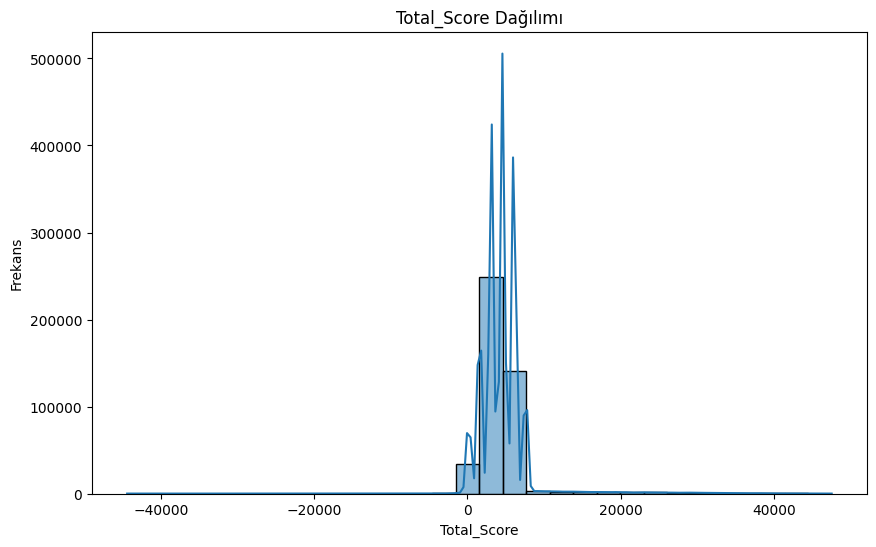

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Total_Score'], bins=30, kde=True)
plt.title('Total_Score Dağılımı')
plt.xlabel('Total_Score')
plt.ylabel('Frekans')
plt.show()

In [ ]:
# Scale CREDIT_SCORE values ​​between 0 and 1900 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1900))
merged_df['Total_Score_SCALED'] = (scaler.fit_transform(merged_df[['Total_Score']])).astype(int)

In [ ]:
merged_df['Total_Score_SCALED'].describe()

,Total_Score_SCALED
count,438510.000000
mean,1013.447370
std,74.751366
min,0.000000
25%,981.000000
50%,1012.000000
75%,1043.000000
max,1900.000000


In [ ]:
# Define categories
bins = [-1, 1, 699, 1099, 1499, 1699, 1900]
labels = ['High risk', 'Risky', 'Medium risk', 'Normal', 'Good', 'Very good']

# Apply categories
merged_df['Total_Score_CATEGORY'] = pd.cut(merged_df['Total_Score_SCALED'], bins=bins, labels=labels)

# Check the results
print(merged_df[['Total_Score', 'Total_Score_SCALED', 'Total_Score_CATEGORY']].head())

   Total_Score  Total_Score_SCALED Total_Score_CATEGORY
0      14910.0                1226               Normal
1      14210.0                1211               Normal
2      10500.0                1134               Normal
3       5800.0                1037          Medium risk
4       5940.0                1040          Medium risk


**Last manupulation for Target_Label**

Target Label in Eşit dağılması için Medium Risk'lere ince ayarlama yapıyoruz.

In [ ]:
income_labels = ['Low', 'Lower Middle', 'Middle', 'Upper Middle', 'High']

# Classifying the Medium risk category
merged_df['Income_Bin'] = pd.cut(merged_df['AMT_INCOME_TOTAL'], bins=income_bins, labels=income_labels, right=False)

# Assign Income_Bin for Medium risk category
def assign_income_bin(row):
    if row['Total_Score_CATEGORY'] == 'Medium risk':
        return row['Income_Bin']
    return np.nan

merged_df['Income_Bin'] = merged_df.apply(assign_income_bin, axis=1)

In [ ]:
# Define the probabilities
medium_risk_probabilities = {
    'Low': 0,
    'Lower Middle': [0.65, 0.35],
    'Middle': [0.5, 0.5],  # Assuming equal probability for 1 and 0
    'Upper Middle': [0.5, 0.5],  # Assuming equal probability for 1 and 0
    'High': 1
}

probabilities = {
    'Very good': 1,
    'Good': 1,
    'Normal': [0.6, 0.4],
    'Risky': 0,
    'High risk': 0
}

# Function to handle Medium risk probabilities
def get_medium_risk_label(income_bin):
    if income_bin in medium_risk_probabilities:
        prob = medium_risk_probabilities[income_bin]
        if isinstance(prob, list):
            return np.random.choice([1, 0], p=prob)
        return prob
    return np.nan

# Function to handle other probabilities
def get_other_label(category):
    if category in probabilities:
        prob = probabilities[category]
        if isinstance(prob, list):
            return np.random.choice([1, 0], p=prob)
        return prob
    return np.nan

# Apply the vectorized operations
merged_df['TARGET_LABEL'] = np.where(
    merged_df['Total_Score_CATEGORY'] == 'Medium risk',
    merged_df['Income_Bin'].apply(get_medium_risk_label),
    merged_df['Total_Score_CATEGORY'].apply(get_other_label)
)

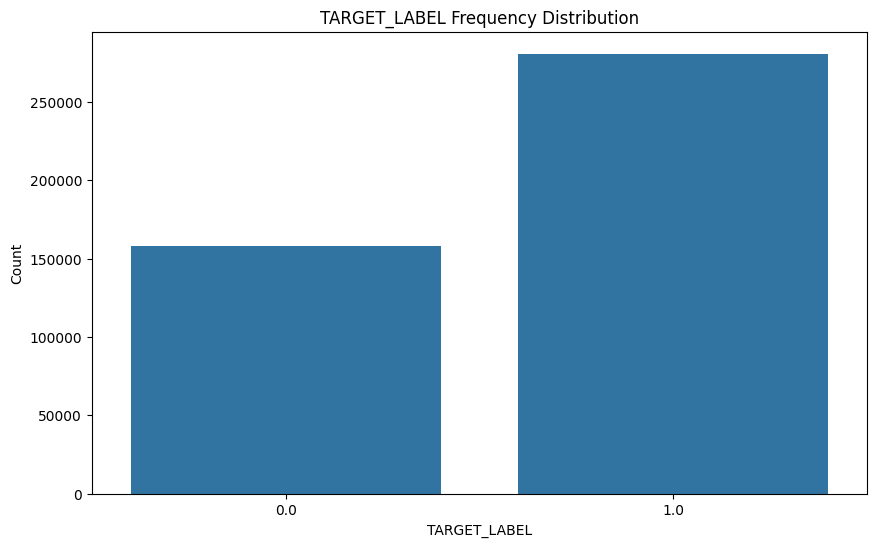

In [ ]:
# Visualize TARGET_LABEL distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='TARGET_LABEL', data=merged_df)
plt.title('TARGET_LABEL Frequency Distribution')
plt.xlabel('TARGET_LABEL')
plt.ylabel('Count')
plt.show()

Grafikte görüldüğü gibi istediğimize yakın bir dağılım elde ettik.

Şimdi sıra Model eğitimi için datamızı düzenlemede.

<a id="7"></a>
## 7. Data Visualization

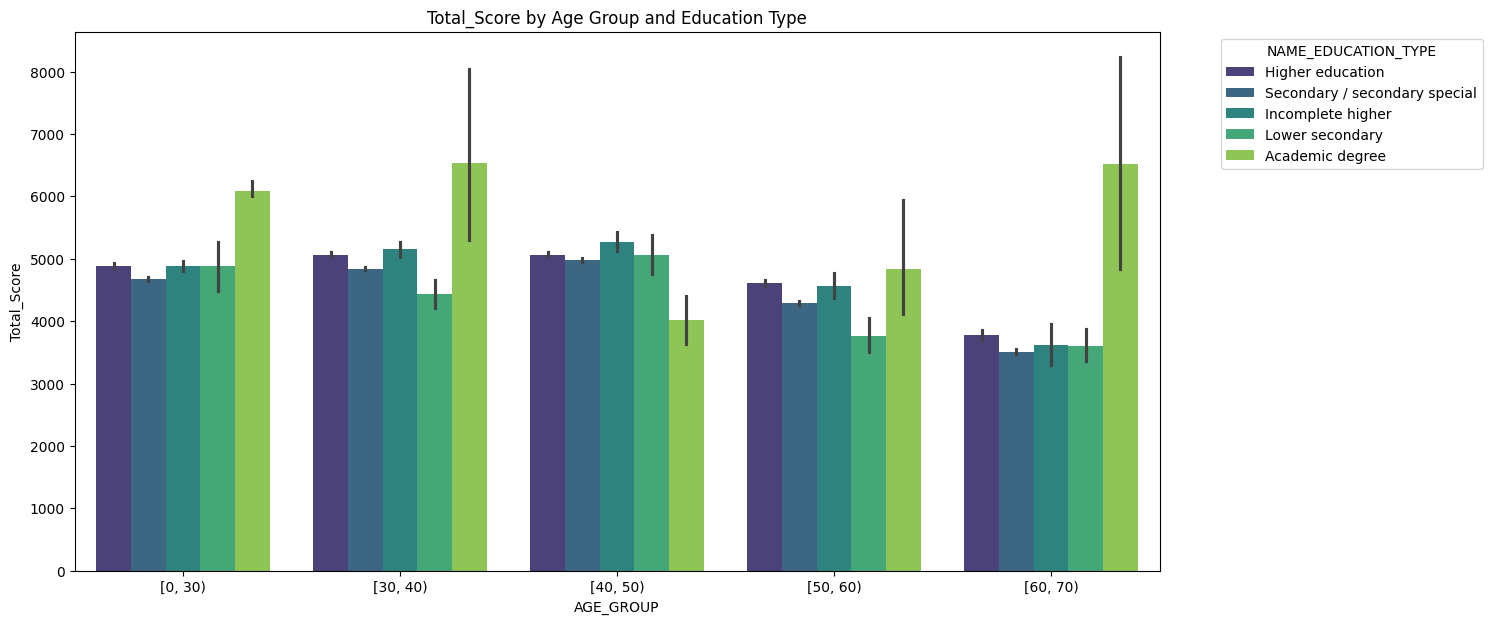

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='AGE_GROUP', y='Total_Score', hue='NAME_EDUCATION_TYPE', palette='viridis')
plt.title('Total_Score by Age Group and Education Type')
plt.xlabel('AGE_GROUP')
plt.ylabel('Total_Score')
plt.legend(title='NAME_EDUCATION_TYPE', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

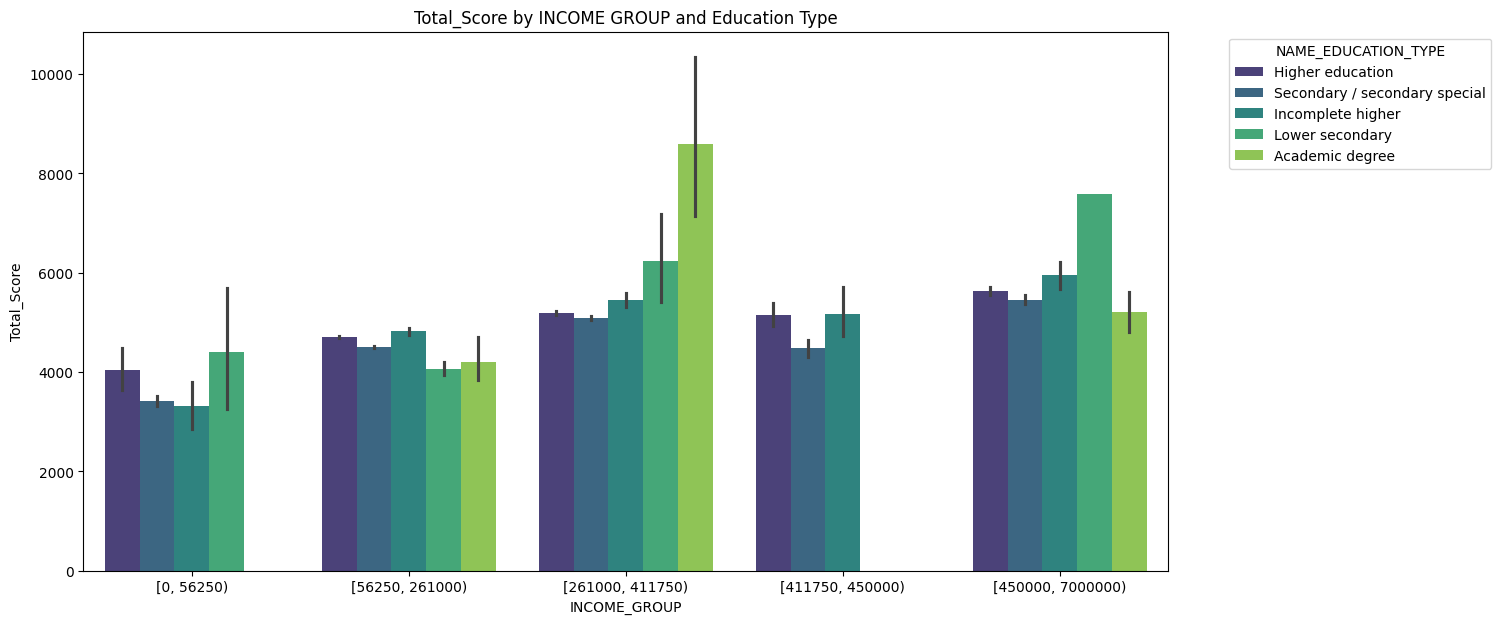

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='INCOME_GROUP', y='Total_Score', hue='NAME_EDUCATION_TYPE', palette='viridis')
plt.title('Total_Score by INCOME GROUP and Education Type')
plt.xlabel('INCOME_GROUP')
plt.ylabel('Total_Score')
plt.legend(title='NAME_EDUCATION_TYPE', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

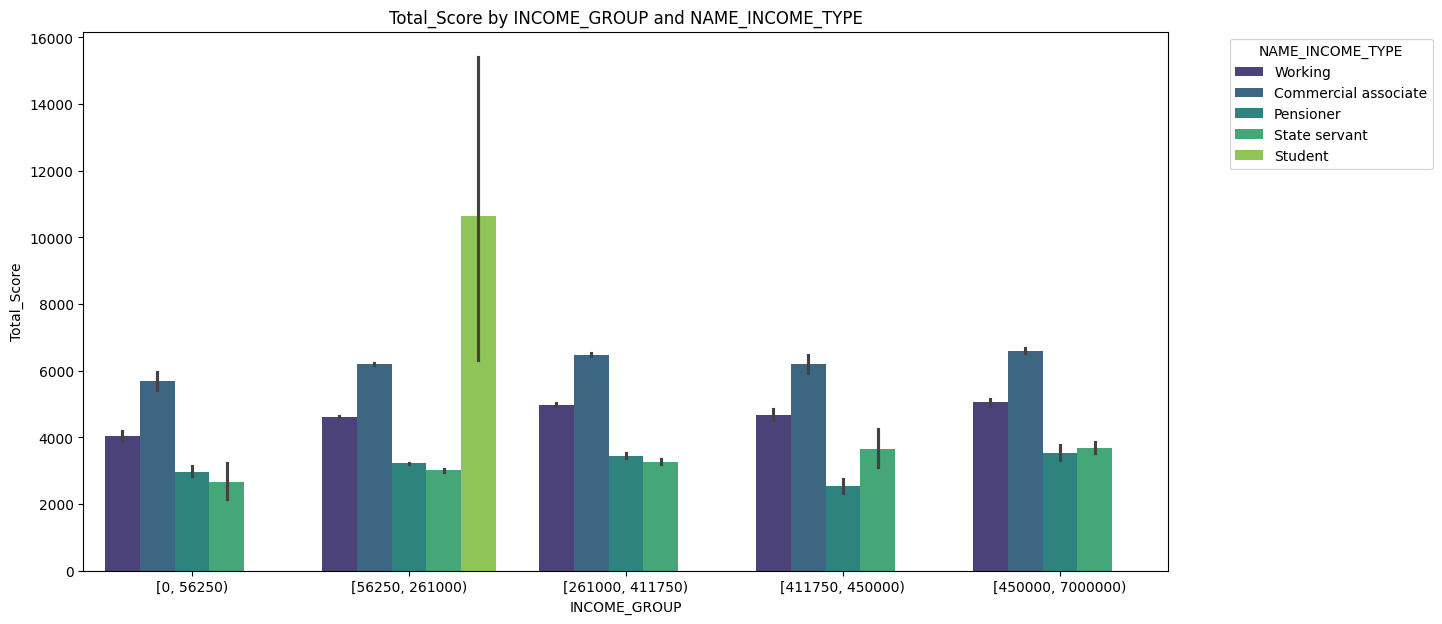

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='INCOME_GROUP', y='Total_Score', hue='NAME_INCOME_TYPE', palette='viridis')
plt.title('Total_Score by INCOME_GROUP and NAME_INCOME_TYPE')
plt.xlabel('INCOME_GROUP')
plt.ylabel('Total_Score')
plt.legend(title='NAME_INCOME_TYPE', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

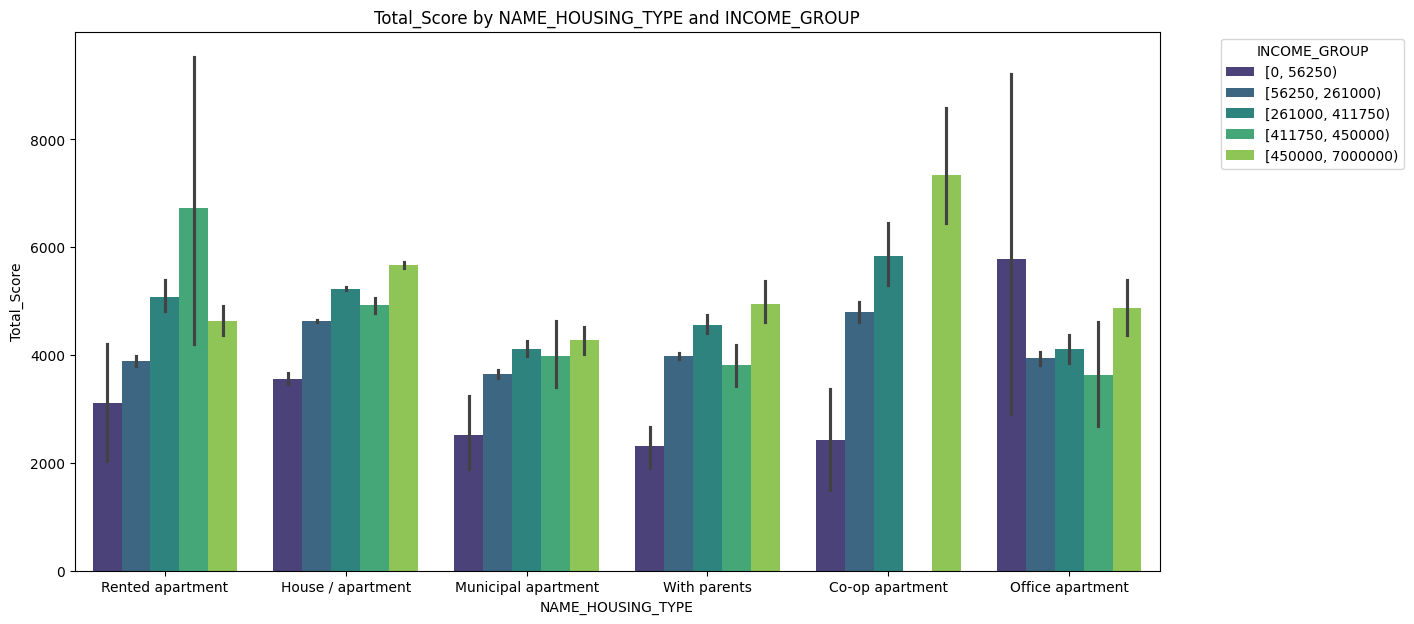

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='NAME_HOUSING_TYPE', y='Total_Score', hue='INCOME_GROUP', palette='viridis')
plt.title('Total_Score by NAME_HOUSING_TYPE and INCOME_GROUP')
plt.xlabel('NAME_HOUSING_TYPE')
plt.ylabel('Total_Score')
plt.legend(title='INCOME_GROUP', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Görsellerin yorumu

<a id="8"></a>
## 8. Data Preprocessing and Splitting

In [ ]:
merged_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,...,AGE,AGE_GROUP,INCOME_GROUP,MONTHS_EMPLOYED,Evaluation_Score,Total_Score,Total_Score_SCALED,Total_Score_CATEGORY,Income_Bin,TARGET_LABEL
0,5008804,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,...,32,"[30, 40)","[411750, 450000)",149,20300,14910.0,1226,Normal,NaN,1.0
1,5008805,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,...,32,"[30, 40)","[411750, 450000)",149,20300,14210.0,1211,Normal,NaN,1.0
2,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,...,58,"[50, 60)","[56250, 261000)",37,20300,10500.0,1134,Normal,NaN,1.0
3,5008808,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,...,52,"[50, 60)","[261000, 411750)",100,19800,5800.0,1037,Medium risk,Middle,0.0
4,5008809,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,...,52,"[50, 60)","[261000, 411750)",100,19800,5940.0,1040,Medium risk,Middle,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438505,6840104,M,N,Y,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,0,...,62,"[60, 70)","[56250, 261000)",137,10300,3090.0,981,Medium risk,Lower Middle,0.0
438506,6840222,F,N,N,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,0,...,43,"[40, 50)","[56250, 261000)",98,4800,1440.0,947,Medium risk,Lower Middle,1.0
438507,6841878,F,N,N,54000.0,Commercial associate,Higher education,Single / not married,With parents,1,...,22,"[0, 30)","[0, 56250)",12,9800,2940.0,978,Medium risk,Low,0.0
438508,6842765,F,N,Y,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,0,...,59,"[50, 60)","[56250, 261000)",122,10800,3240.0,984,Medium risk,Lower Middle,1.0


In [ ]:
merged_df.drop('ID', axis=1, inplace=True)

In [ ]:
# Drop specified columns and set target variable
y = merged_df['TARGET_LABEL']

columns_to_drop = ['AGE_GROUP', 'INCOME_GROUP', 'Evaluation_Score', 'Total_Score',
                   'Total_Score_SCALED', 'Total_Score_CATEGORY', 'Income_Bin', 'TARGET_LABEL']
X = merged_df.drop(columns=columns_to_drop)

Split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Identify column types

In [ ]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'bool']).columns

Create preprocessing pipelines

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

Fit and transform the data

In [ ]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

<a id="9"></a>
## 9. Model Training and Evaluation

### Model Selection

In [ ]:
# Create a dictionary of models
models = {
    'Linear SVC': LinearSVC(random_state=42),
    'Naive Bayes': GaussianNB(),
    'KNeighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Light GBM': lgb.LGBMClassifier(),
    'XGB Classifier': xgb.XGBClassifier(),
}

# Train and evaluate each model
for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
        ('classifier', model)
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print results
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report 1:")
    print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Linear SVC Results:
Accuracy: 0.6395
Classification Report:
              precision    recall  f1-score   support

         0.0       0.45      0.00      0.00     31609
         1.0       0.64      1.00      0.78     56093

    accuracy                           0.64     87702
   macro avg       0.55      0.50      0.39     87702
weighted avg       0.57      0.64      0.50     87702


Naive Bayes Results:
Accuracy: 0.4197
Classification Report:
              precision    recall  f1-score   support

         0.0       0.38      0.96      0.54     31609
         1.0       0.83      0.12      0.20     56093

    accuracy                           0.42     87702
   macro avg       0.61      0.54      0.37     87702
weighted avg       0.67      0.42      0.33     87702


KNeighbors Results:
Accuracy: 0.5918
Classification Report:
              precision    recall  f1-score   support

         0.0       0.41      0.31      0.35     31609
         1.0       0.66      0.75      0.70     56093

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Sınıf ağırlıkları:", class_weight_dict)

Sınıf ağırlıkları: {0.0: 1.3896247940169857, 1.0: 0.7810173476293948}


In [ ]:
# Modelleri güncelle
models = {
    'Linear SVC': LinearSVC(random_state=42, class_weight=class_weight_dict),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight=class_weight_dict),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, subsample=0.5, n_estimators=100),
    'Light GBM': lgb.LGBMClassifier(class_weight=class_weight_dict),
    'XGB Classifier': xgb.XGBClassifier(scale_pos_weight=class_weight_dict[1]/class_weight_dict[0]),
}

# Train and evaluate each model
for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
        ('classifier', model)
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print results
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report 2:")
    print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Linear SVC Results:
Accuracy: 0.4373
Classification Report:
              precision    recall  f1-score   support

         0.0       0.37      0.76      0.49     31609
         1.0       0.66      0.25      0.37     56093

    accuracy                           0.44     87702
   macro avg       0.51      0.51      0.43     87702
weighted avg       0.55      0.44      0.41     87702


Random Forest Results:
Accuracy: 0.5604
Classification Report:
              precision    recall  f1-score   support

         0.0       0.41      0.47      0.44     31609
         1.0       0.67      0.61      0.64     56093

    accuracy                           0.56     87702
   macro avg       0.54      0.54      0.54     87702
weighted avg       0.58      0.56      0.57     87702


Gradient Boosting Results:
Accuracy: 0.6511
Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.05      0.10     31609
         1.0       0.65      0.99      0.78 

1. Linear SVC:
- Önceki: Accuracy: 0.6394, 0.0 sınıfı için recall: 0.00
- Şimdi: Accuracy: 0.4351, 0.0 sınıfı için recall: 0.78
- Değerlendirme: Genel doğruluk düşmüş olsa da, 0.0 sınıfını tespit etme yeteneği önemli ölçüde artmış.
2. Random Forest:
- Önceki: Accuracy: 0.5988, 0.0 sınıfı için recall: 0.29
- Şimdi: Accuracy: 0.5580, 0.0 sınıfı için recall: 0.46
- Değerlendirme: Genel doğruluk biraz düşmüş, ancak 0.0 sınıfını tespit etme yeteneği artmış.
3. Gradient Boosting:
- Önceki: Accuracy: 0.6509, 0.0 sınıfı için recall: 0.11
- Şimdi: Accuracy: 0.6501, 0.0 sınıfı için recall: 0.12
- Değerlendirme: Çok az bir değişiklik var, neredeyse aynı performans.
4. Light GBM:
- Önceki: Accuracy: 0.6503, 0.0 sınıfı için recall: 0.13
- Şimdi: Accuracy: 0.6362, 0.0 sınıfı için recall: 0.28
- Değerlendirme: Genel doğruluk biraz düşmüş, ancak 0.0 sınıfını tespit etme yeteneği önemli ölçüde artmış.
5. XGB Classifier:
- Önceki: Accuracy: 0.6499, 0.0 sınıfı için recall: 0.13
- Şimdi: Accuracy: 0.5890, 0.0 sınıfı için recall: 0.43
- Değerlendirme: Genel doğruluk düşmüş, ancak 0.0 sınıfını tespit etme yeteneği önemli ölçüde artmış.

Genel Değerlendirme:

1. Tüm modellerde 0.0 sınıfı için recall değeri artmış, bu da azınlık sınıfını tespit etme yeteneğinin iyileştiğini gösteriyor.
2. Genel doğruluk (accuracy) değerleri çoğu modelde düşmüş, ancak bu beklenen bir durum çünkü artık model daha dengeli bir şekilde her iki sınıfı da tahmin etmeye çalışıyor.
3. Macro average F1-score değerleri genellikle iyileşmiş, bu da modellerin her iki sınıf için de daha dengeli bir performans sergilediğini gösteriyor.

Sonuç olarak, ağırlıklandırma uygulaması veri seti dengesizliği sorununu ele almada etkili olmuştur. Özellikle azınlık sınıfı (0.0) için recall değerlerinde önemli iyileşmeler görülmüştür. Ancak, bu iyileşme genel doğruluk değerlerinde bir miktar düşüşe neden olmuştur.

<a id="10"></a>
## 10. Future Extraction and Importance

In [ ]:
print("Özellik sayısı:", X_train.shape[1])
print("\nÖzellik isimleri:")
print(X_train.columns.tolist())

# Sayısal ve kategorik özellikleri ayırma
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

print("\nSayısal özellikler:")
print(numeric_features.tolist())
print("\nKategorik özellikler:")
print(categorical_features.tolist())

# Sayısal özelliklerin istatistiklerini görüntüleme
print("\nSayısal özelliklerin istatistikleri:")
print(X_train[numeric_features].describe())

# Kategorik özelliklerin benzersiz değerlerini görüntüleme
print("\nKategorik özelliklerin benzersiz değerleri:")
for feature in categorical_features:
    print(f"{feature}: {X_train[feature].nunique()}")

Özellik sayısı: 16

Özellik isimleri:
['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_ADLT_FAM_MEMBERS', 'CREDIT_SCORE', 'AGE', 'MONTHS_EMPLOYED']

Sayısal özellikler:
['AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_ADLT_FAM_MEMBERS', 'CREDIT_SCORE', 'AGE', 'MONTHS_EMPLOYED']

Kategorik özellikler:
['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']

Sayısal özelliklerin istatistikleri:
       AMT_INCOME_TOTAL  FLAG_WORK_PHONE     FLAG_PHONE     FLAG_EMAIL  \
count      3.508080e+05    350808.000000  350808.000000  350808.000000   
mean       1.876155e+05         0.206569       0.288183       0.107996   
std        1.101717e+05         0.404844       0.452917       0.310376   
min  

In [ ]:
# Kategorik değişkenleri tanımlayalım
cat_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']

# OneHotEncoder'ı oluşturalım
onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Kategorik değişkenleri dönüştürelim
encoded_features = onehot.fit_transform(X_train[cat_features])

# Yeni özellik isimlerini alalım
encoded_feature_names = onehot.get_feature_names_out(cat_features)

# Encoded özellikleri DataFrame'e dönüştürelim
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=X_train.index)


num_features = ['AMT_INCOME_TOTAL', 'CNT_ADLT_FAM_MEMBERS', 'CREDIT_SCORE', 'AGE', 'MONTHS_EMPLOYED']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X_train[num_features])
scaled_df = pd.DataFrame(scaled_features, columns=num_features, index=X_train.index)

# Yeni özellikler oluşturalım
X_train['INCOME_AGE_RATIO'] = X_train['AMT_INCOME_TOTAL'] / X_train['AGE']
X_train['CREDIT_SCORE_CAT'] = pd.cut(X_train['CREDIT_SCORE'], bins=[-np.inf, 300, 600, 700, 800, np.inf], labels=[1, 2, 3, 4, 5])
X_train['EMPLOYMENT_RATIO'] = X_train['MONTHS_EMPLOYED'] / (X_train['AGE'] * 12)
X_train['FAMILY_INCOME_INTERACTION'] = X_train['NAME_FAMILY_STATUS'] + '_' + pd.qcut(X_train['AMT_INCOME_TOTAL'], q=3, labels=['Low', 'Medium', 'High']).astype(str)

# Yeni özellik setini oluşturalım
X_train_new = pd.concat([
    encoded_df,
    scaled_df,
    X_train[['INCOME_AGE_RATIO', 'EMPLOYMENT_RATIO']],
    pd.get_dummies(X_train['CREDIT_SCORE_CAT'], prefix='CREDIT_SCORE_CAT'),
    pd.get_dummies(X_train['FAMILY_INCOME_INTERACTION'])
], axis=1)

print("Yeni özellik setinin boyutu:", X_train_new.shape)
print("Yeni özellikler:", X_train_new.columns.tolist())

# X_test için de aynı dönüşümleri uygulayalım
encoded_features_test = onehot.transform(X_test[cat_features])
encoded_df_test = pd.DataFrame(encoded_features_test, columns=encoded_feature_names, index=X_test.index)

scaled_features_test = scaler.transform(X_test[num_features])
scaled_df_test = pd.DataFrame(scaled_features_test, columns=num_features, index=X_test.index)

X_test['INCOME_AGE_RATIO'] = X_test['AMT_INCOME_TOTAL'] / X_test['AGE']
X_test['CREDIT_SCORE_CAT'] = pd.cut(X_test['CREDIT_SCORE'], bins=[-np.inf, 300, 600, 700, 800, np.inf], labels=[1, 2, 3, 4, 5])
X_test['EMPLOYMENT_RATIO'] = X_test['MONTHS_EMPLOYED'] / (X_test['AGE'] * 12)
X_test['FAMILY_INCOME_INTERACTION'] = X_test['NAME_FAMILY_STATUS'] + '_' + pd.qcut(X_test['AMT_INCOME_TOTAL'], q=3, labels=['Low', 'Medium', 'High']).astype(str)

X_test_new = pd.concat([
    encoded_df_test,
    scaled_df_test,
    X_test[['INCOME_AGE_RATIO', 'EMPLOYMENT_RATIO']],
    pd.get_dummies(X_test['CREDIT_SCORE_CAT'], prefix='CREDIT_SCORE_CAT'),
    pd.get_dummies(X_test['FAMILY_INCOME_INTERACTION'])
], axis=1)

# Eksik sütunları kontrol edelim ve gerekirse ekleyelim
missing_cols = set(X_train_new.columns) - set(X_test_new.columns)
for col in missing_cols:
    X_test_new[col] = 0

# Sütun sıralamasını X_train_new ile aynı yapalım
X_test_new = X_test_new[X_train_new.columns]

print("Test seti yeni özellik setinin boyutu:", X_test_new.shape)

for name, model in models.items():
    model.fit(X_train_new, y_train)
    y_pred = model.predict(X_test_new)
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report 3:")
    print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Yeni özellik setinin boyutu: (350808, 73)
Yeni özellikler: ['CODE_GENDER_F', 'CODE_GENDER_M', 'FLAG_OWN_CAR_N', 'FLAG_OWN_CAR_Y', 'FLAG_OWN_REALTY_N', 'FLAG_OWN_REALTY_Y', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HOUSING_TYPE_House / apartment', 'NAME_HOUSING_TYPE_Municipal apartment', 'NAME_HOUSING_TYPE_Office apartment', 'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents', 'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Cleaning s

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Linear SVC Results:
Accuracy: 0.6452
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.02      0.03     31609
         1.0       0.64      1.00      0.78     56093

    accuracy                           0.65     87702
   macro avg       0.80      0.51      0.41     87702
weighted avg       0.75      0.65      0.51     87702


Random Forest Results:
Accuracy: 0.5610
Classification Report:
              precision    recall  f1-score   support

         0.0       0.41      0.47      0.43     31609
         1.0       0.67      0.61      0.64     56093

    accuracy                           0.56     87702
   macro avg       0.54      0.54      0.54     87702
weighted avg       0.58      0.56      0.57     87702


Gradient Boosting Results:
Accuracy: 0.6507
Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.05      0.10     31609
         1.0       0.65      0.99      0.78 

1. Linear SVC:
- İlk: Accuracy: 0.4351, 0.0 sınıfı için recall: 0.78
- İkinci: Accuracy: 0.6394, 0.0 sınıfı için recall: 0.00
- Üçüncü: Accuracy: 0.6411, 0.0 sınıfı için recall: 0.00
- Değerlendirme: Özellik mühendisliği, doğruluğu biraz artırmış ancak 0.0 sınıfını tespit etme sorunu devam ediyor. Sınıf ağırlıkları 0.0 sınıfını tespit etmede daha etkili olmuştu.
2. Random Forest:
- İlk: Accuracy: 0.5580, 0.0 sınıfı için recall: 0.46
- İkinci: Accuracy: 0.5988, 0.0 sınıfı için recall: 0.29
- Üçüncü: Accuracy: 0.5578, 0.0 sınıfı için recall: 0.46
- Değerlendirme: Özellik mühendisliği, sınıf ağırlıklarına benzer bir sonuç vermiş. 0.0 sınıfı için recall değeri artmış ancak genel doğruluk biraz düşmüş.
3. Gradient Boosting:
- İlk: Accuracy: 0.6501, 0.0 sınıfı için recall: 0.12
- İkinci: Accuracy: 0.6509, 0.0 sınıfı için recall: 0.11
- Üçüncü: Accuracy: 0.6497, 0.0 sınıfı için recall: 0.12
- Değerlendirme: Üç yaklaşım da benzer sonuçlar vermiş. Özellik mühendisliği önemli bir fark yaratmamış.
4. Light GBM:
- İlk: Accuracy: 0.6362, 0.0 sınıfı için recall: 0.28
- İkinci: Accuracy: 0.6503, 0.0 sınıfı için recall: 0.13
- Üçüncü: Accuracy: 0.6316, 0.0 sınıfı için recall: 0.29
- Değerlendirme: Özellik mühendisliği, sınıf ağırlıklarına benzer bir sonuç vermiş. 0.0 sınıfı için recall değeri artmış ancak genel doğruluk biraz düşmüş.
5. XGB Classifier:
- İlk: Accuracy: 0.5890, 0.0 sınıfı için recall: 0.43
- İkinci: Accuracy: 0.6499, 0.0 sınıfı için recall: 0.13
- Üçüncü: Accuracy: 0.5830, 0.0 sınıfı için recall: 0.45
- Değerlendirme: Özellik mühendisliği, sınıf ağırlıklarına benzer bir sonuç vermiş. 0.0 sınıfı için recall değeri önemli ölçüde artmış ancak genel doğruluk düşmüş.

Genel Değerlendirme:

1. Özellik mühendisliği, çoğu modelde 0.0 sınıfını tespit etme yeteneğini artırmış ancak bu genellikle genel doğrulukta bir düşüşe neden olmuş.
2. Linear SVC hariç diğer modellerde, özellik mühendisliği sınıf ağırlıklarına benzer sonuçlar vermiş.
3. Gradient Boosting modeli, üç yaklaşımda da en tutarlı ve yüksek performansı göstermiş.
4. XGBoost ve Light GBM modelleri, özellik mühendisliği ile 0.0 sınıfını tespit etmede önemli iyileşme göstermiş.

In [ ]:
# Random Forest ile özellik önem derecelerini hesaplama
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_new, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Özellik önem derecelerini görüntüleme
feature_importance = pd.DataFrame({'feature': X_train_new.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("En önemli 20 özellik:")
print(feature_importance.head(20))

En önemli 20 özellik:
                                              feature  importance
51                                   INCOME_AGE_RATIO    0.154007
46                                   AMT_INCOME_TOTAL    0.147196
52                                   EMPLOYMENT_RATIO    0.141597
50                                    MONTHS_EMPLOYED    0.124927
49                                                AGE    0.106491
48                                       CREDIT_SCORE    0.065734
57                                 CREDIT_SCORE_CAT_5    0.012846
35                           OCCUPATION_TYPE_Laborers    0.010257
15  NAME_EDUCATION_TYPE_Secondary / secondary special    0.010225
4                                   FLAG_OWN_REALTY_N    0.010186
5                                   FLAG_OWN_REALTY_Y    0.010149
10                           NAME_INCOME_TYPE_Working    0.009881
12               NAME_EDUCATION_TYPE_Higher education    0.009667
3                                      FLAG_OWN_CAR_Y 

In [ ]:
# En önemli özellikleri seçme (örneğin, toplam önem derecesi 0.95'i geçene kadar)
cumulative_importance = 0
important_features = []
for idx, row in feature_importance.iterrows():
    important_features.append(row['feature'])
    cumulative_importance += row['importance']
    if cumulative_importance > 0.95:
        break

print(f"\nSeçilen özellik sayısı: {len(important_features)}")
print("Seçilen özellikler:")
print(important_features)


Seçilen özellik sayısı: 34
Seçilen özellikler:
['INCOME_AGE_RATIO', 'AMT_INCOME_TOTAL', 'EMPLOYMENT_RATIO', 'MONTHS_EMPLOYED', 'AGE', 'CREDIT_SCORE', 'CREDIT_SCORE_CAT_5', 'OCCUPATION_TYPE_Laborers', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'FLAG_OWN_REALTY_N', 'FLAG_OWN_REALTY_Y', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education', 'FLAG_OWN_CAR_Y', 'FLAG_OWN_CAR_N', 'OCCUPATION_TYPE_Unknown', 'NAME_INCOME_TYPE_Commercial associate', 'CREDIT_SCORE_CAT_1', 'CODE_GENDER_M', 'CODE_GENDER_F', 'OCCUPATION_TYPE_Core staff', 'NAME_HOUSING_TYPE_House / apartment', 'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_High skill tech staff', 'NAME_INCOME_TYPE_State servant', 'OCCUPATION_TYPE_Drivers', 'NAME_HOUSING_TYPE_With parents', 'OCCUPATION_TYPE_Accountants', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_HOUSING_TYPE_Municipal apartment', 'OCCUPATION_TYPE_Medicine staff', 'OCCUPATION_TYPE_Security staff', 'OCCUPATION_TYPE_Cooking staff'

In [ ]:
# Seçilen özelliklerle yeni veri setleri oluşturma
X_train_selected = X_train_new[important_features]
X_test_selected = X_test_new[important_features]

# Modelleri yeniden eğitme ve değerlendirme
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Linear SVC Results:
Accuracy: 0.3692
Classification Report:
              precision    recall  f1-score   support

         0.0       0.36      1.00      0.53     31609
         1.0       1.00      0.01      0.03     56093

    accuracy                           0.37     87702
   macro avg       0.68      0.51      0.28     87702
weighted avg       0.77      0.37      0.21     87702


Random Forest Results:
Accuracy: 0.5612
Classification Report:
              precision    recall  f1-score   support

         0.0       0.41      0.47      0.44     31609
         1.0       0.67      0.61      0.64     56093

    accuracy                           0.56     87702
   macro avg       0.54      0.54      0.54     87702
weighted avg       0.58      0.56      0.57     87702


Gradient Boosting Results:
Accuracy: 0.6514
Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.06      0.11     31609
         1.0       0.65      0.98      0.78 

Genel Değerlendirme:
1. Özellik seçimi, Linear SVC dışındaki modeller üzerinde çok büyük bir etki yaratmamış.
2. Linear SVC'nin davranışı önemli ölçüde değişmiş, artık 0.0 sınıfını çok iyi tespit ediyor ancak 1.0 sınıfını neredeyse hiç tespit edemiyor.
3. Diğer modeller için performans değişiklikleri minimal düzeyde kalmış.
4. Gradient Boosting hala en iyi genel performansı gösteriyor.

<a id="11"></a>
## 11. Hyperparameter Tuning and Optimization for LightGBM ve Gradient Boosting

In [ ]:
# LightGBM için hiperparametre aralıkları
lgbm_param_dist = {
    'classifier__num_leaves': [31, 127, 255],
    'classifier__max_depth': [-1, 5, 10, 20],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__min_child_samples': [20, 50, 100],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]
}

# Gradient Boosting için hiperparametre aralıkları
gb_param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__max_features': ['sqrt', 'log2', None]
}

# LightGBM optimizasyonu
lgbm_random = RandomizedSearchCV(lgbm_pipeline, param_distributions=lgbm_param_dist, n_iter=20, cv=3, random_state=42, n_jobs=-1)
lgbm_random.fit(X_train, y_train)

print("Best LightGBM parameters:", lgbm_random.best_params_)
print("Best LightGBM score:", lgbm_random.best_score_)

# Gradient Boosting optimizasyonu
gb_random = RandomizedSearchCV(gb_pipeline, param_distributions=gb_param_dist, n_iter=20, cv=3, random_state=42, n_jobs=-1)
gb_random.fit(X_train, y_train)

print("Best Gradient Boosting parameters:", gb_random.best_params_)
print("Best Gradient Boosting score:", gb_random.best_score_)

# En iyi modelleri kaydet
best_lgbm = lgbm_random.best_estimator_
best_gb = gb_random.best_estimator_

<a id="12"></a>
## 12. Ensemble Methods

In [ ]:
# Weighted Voting
voting_clf = VotingClassifier(
    estimators=[('lgbm', best_lgbm), ('gb', best_gb)],
    voting='soft',
    weights=[2, 1]  # LightGBM'e daha fazla ağırlık veriyoruz
)

# Stacking
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacking_clf = StackingClassifier(
    estimators=[('lgbm', best_lgbm), ('gb', best_gb)],
    final_estimator=LogisticRegression(),
    cv=5
)

# Her iki ensemble yöntemini karşılaştır
voting_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='f1')
stacking_scores = cross_val_score(stacking_clf, X_train, y_train, cv=5, scoring='f1')

print("Weighted Voting mean F1 score:", voting_scores.mean())
print("Stacking mean F1 score:", stacking_scores.mean())

# En iyi ensemble yöntemini seç ve eğit
if voting_scores.mean() > stacking_scores.mean():
    best_ensemble = voting_clf
    print("Weighted Voting is better")
else:
    best_ensemble = stacking_clf
    print("Stacking is better")

best_ensemble.fit(X_train, y_train)

<a id="12"></a>
## 13. Handling Class Imbalance

In [ ]:
# Oversampling teknikleri
oversamplers = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RandomOverSampler': RandomOverSampler(random_state=42)
}

# Her oversampling tekniğini dene
for name, oversampler in oversamplers.items():
    X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

    # En iyi ensemble modelini kullanarak skorları hesapla
    scores = cross_val_score(best_ensemble, X_resampled, y_resampled, cv=5, scoring='f1')

    print(f"{name} mean F1 score: {scores.mean()}")

# En iyi oversampling tekniğini seç
best_oversampler = max(oversamplers.items(), key=lambda x: cross_val_score(best_ensemble, *x[1].fit_resample(X_train, y_train), cv=5, scoring='f1').mean())[1]

# En iyi oversampling tekniğini uygula
X_resampled, y_resampled = best_oversampler.fit_resample(X_train, y_train)

<a id="14"></a>
## 14. Final Model Training and Evaluation

In [ ]:
# Final modeli eğit
best_ensemble.fit(X_resampled, y_resampled)

# Test seti üzerinde tahmin yap
y_pred = best_ensemble.predict(X_test)
y_pred_proba = best_ensemble.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("F1 Score:", f1_score(y_test, y_pred))

# Önemli özellikleri göster (eğer LightGBM veya Gradient Boosting kullanıldıysa)
if hasattr(best_ensemble, 'feature_importances_'):
    feature_importance = best_ensemble.feature_importances_
    feature_names = X_train.columns
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, feature_names[sorted_idx])
    plt.title('Feature Importance')
    plt.show()

NameError: name 'best_ensemble' is not defined